# Cell 1: Import necessary libraries
In this cell we import libraries for numerical computations (NumPy), data management (Pandas), statistical modeling (Statsmodels), visualization (Matplotlib and Seaborn), and for clustering (KMeans from scikit‑learn). 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline

# Cell 2: Create dummy data (similar to data_censored in R)
In this cell we simulate a dataset with 200 patients, including columns such as treatment, outcome, eligibility, and several covariates. A binary variable age_binary is created for use in logistic regression. This dataset mimics the "data_censored" example from the R code.

In [2]:
np.random.seed(42)
n = 200  # number of patients
data_censored = pd.DataFrame({
    'id': np.arange(1, n+1),
    'period': 1,
    'treatment': np.random.binomial(1, 0.5, n),
    'outcome': np.random.normal(0, 1, n),
    'eligible': np.random.binomial(1, 0.8, n),
    'age': np.random.normal(50, 10, n),
    'x1': np.random.normal(0, 1, n),
    'x2': np.random.normal(0, 1, n),
    'x3': np.random.normal(0, 1, n),
    'censored': np.random.binomial(1, 0.1, n)
})

# Create a binary indicator variable for logistic regression modeling (e.g., age > 50)
data_censored['age_binary'] = (data_censored['age'] > 50).astype(int)

print("Head of dummy data:")
print(data_censored.head())

Head of dummy data:
   id  period  treatment   outcome  eligible        age        x1        x2  \
0   1       1          0 -0.680025         1  65.231241  0.593101  1.382159   
1   2       1          1  0.232254         0  55.389100 -0.309546  0.648710   
2   3       1          1  0.293072         1  39.627538  0.326133 -0.167118   
3   4       1          1 -0.714351         1  48.096613 -1.251114  0.146714   
4   5       1          0  1.865775         1  41.243817  0.924027  1.206509   

         x3  censored  age_binary  
0  0.732640         1           1  
1 -0.080717         0           1  
2  0.078635         0           0  
3 -1.998201         1           0  
4  0.916328         0           0  


# Cell 2A: Apply clustering on baseline covariates
In this new cell we introduce a clustering mechanism using KMeans on the baseline variables (age, x1, x2, and x3). The resulting cluster labels are stored in the new column cluster and we visualize the clusters using Seaborn’s pairplot. This step helps us understand if the population divides into distinct subgroups, which may exhibit different survival or treatment response patterns.

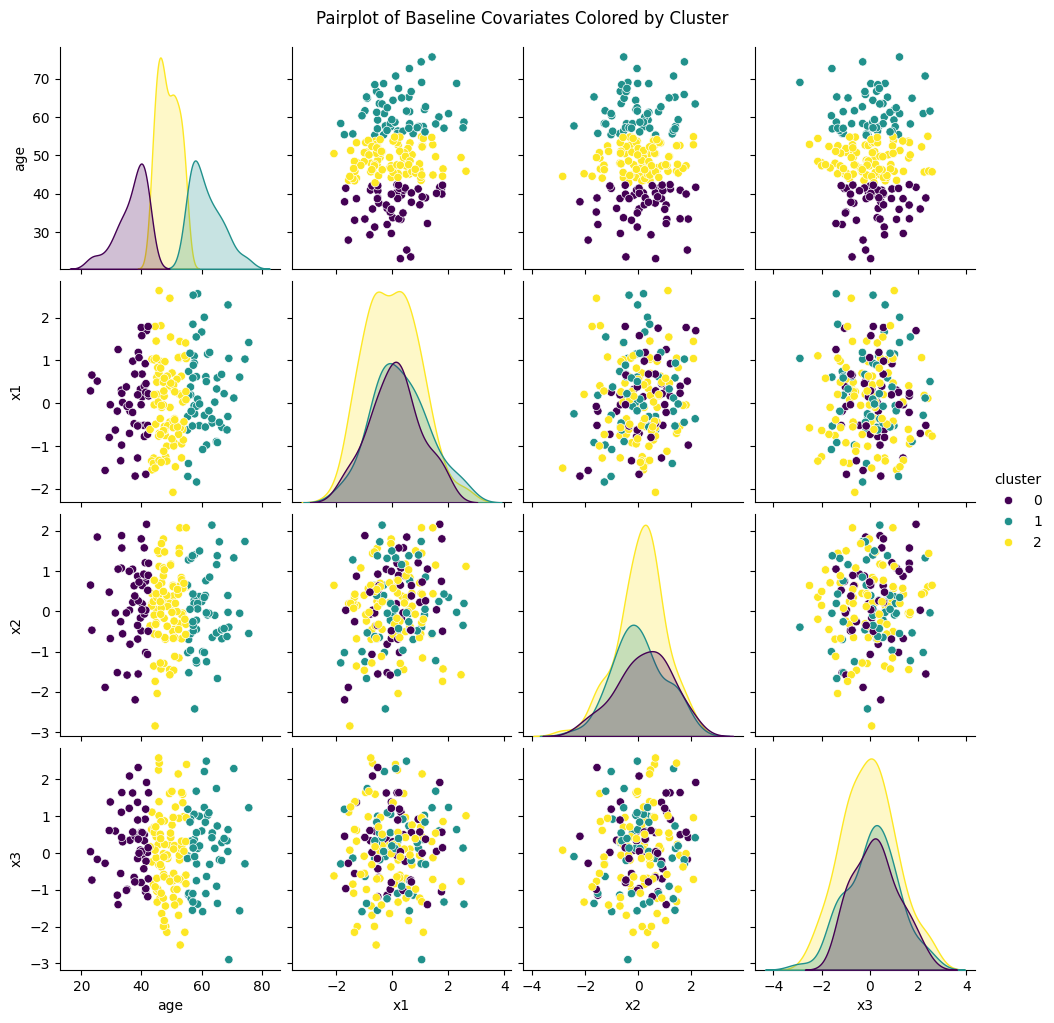

Cluster counts:
cluster
2    93
1    57
0    50
Name: count, dtype: int64


In [3]:
cluster_features = data_censored[['age', 'x1', 'x2', 'x3']]
kmeans = KMeans(n_clusters=3, random_state=42)
data_censored['cluster'] = kmeans.fit_predict(cluster_features)

# Visualize the cluster distribution using a pairplot.
sns.pairplot(data_censored, vars=['age', 'x1', 'x2', 'x3'], hue='cluster', palette='viridis')
plt.suptitle("Pairplot of Baseline Covariates Colored by Cluster", y=1.02)
plt.show()

print("Cluster counts:")
print(data_censored['cluster'].value_counts())

# Cell 3: Define the TrialSequence class to simulate trial emulation steps
This cell defines the TrialSequence class, which encapsulates each step of the trial emulation process. The class methods include data loading, fitting weight models for treatment switching and censoring, computing weights, fitting outcome models, expanding the dataset for longitudinal analysis, fitting a marginal structural model (MSM), and predicting survival differences over time.

In [4]:
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand  # "PP" for Per-Protocol or "ITT" for Intention-to-Treat
        self.data = None
        self.expanded_data = None

    def set_data(self, data, id_col, period, treatment, outcome, eligible):
        self.data = data.copy()
        self.id_col = id_col
        self.period = period
        self.treatment = treatment
        self.outcome = outcome
        self.eligible = eligible
        return self

    def set_switch_weight_model(self, numerator_formula, denominator_formula):
        if self.estimand != "PP":
            print("Switch weight model is only applicable for PP estimand")
            return self
        self.switch_numerator_formula = numerator_formula
        self.switch_denominator_formula = denominator_formula
        self.switch_num_model = smf.glm(formula=numerator_formula, data=self.data, 
                                        family=sm.families.Binomial()).fit()
        self.switch_den_model = smf.glm(formula=denominator_formula, data=self.data, 
                                        family=sm.families.Binomial()).fit()
        return self

    def set_censor_weight_model(self, censor_event, numerator_formula, denominator_formula, pool_models="none"):
        self.censor_event = censor_event
        self.censor_num_formula = numerator_formula
        self.censor_den_formula = denominator_formula
        self.pool_models = pool_models
        self.censor_num_model = smf.glm(formula=numerator_formula, data=self.data, 
                                        family=sm.families.Binomial()).fit()
        self.censor_den_model = smf.glm(formula=denominator_formula, data=self.data, 
                                        family=sm.families.Binomial()).fit()
        return self

    def calculate_weights(self):
        if self.estimand == "PP":
            pred_switch_num = self.switch_num_model.predict(self.data)
            pred_switch_den = self.switch_den_model.predict(self.data)
            switch_weight = pred_switch_num / pred_switch_den
        else:
            switch_weight = 1.0
        pred_censor_num = self.censor_num_model.predict(self.data)
        pred_censor_den = self.censor_den_model.predict(self.data)
        censor_weight = pred_censor_num / pred_censor_den
        self.data['weight'] = switch_weight * censor_weight
        return self

    def show_weight_models(self):
        print("Censor weight model summary:")
        print(self.censor_den_model.summary())
        if self.estimand == "PP":
            print("\nSwitch weight model summary:")
            print(self.switch_den_model.summary())

    def set_outcome_model(self, adjustment_terms=None):
        formula = f"{self.outcome} ~ {self.treatment}"
        if adjustment_terms:
            formula += " + " + adjustment_terms
        self.outcome_formula = formula
        self.outcome_model = smf.wls(formula=formula, data=self.data, weights=self.data['weight']).fit()
        return self

    def set_expansion_options(self, chunk_size=500):
        expanded = []
        for _, row in self.data.iterrows():
            for t in range(11):  # simulate follow-up times 0 through 10
                new_row = row.copy()
                new_row['followup_time'] = t
                expanded.append(new_row)
        self.expanded_data = pd.DataFrame(expanded)
        return self

    def expand_trials(self):
        return self

    def load_expanded_data(self, seed=1234, p_control=0.5):
        np.random.seed(seed)
        if self.expanded_data is not None:
            control = self.expanded_data[self.expanded_data[self.treatment] == 0]
            treated = self.expanded_data[self.expanded_data[self.treatment] == 1]
            control_sampled = control.sample(frac=p_control)
            self.expanded_data = pd.concat([treated, control_sampled], ignore_index=True)
        return self

    def fit_msm(self, weight_col='weight'):
        w = self.expanded_data[weight_col]
        q99 = w.quantile(0.99)
        self.expanded_data['w_mod'] = np.where(w > q99, q99, w)
        msm_formula = f"{self.outcome} ~ {self.treatment} + followup_time"
        self.msm_model = smf.wls(formula=msm_formula, data=self.expanded_data, 
                                 weights=self.expanded_data['w_mod']).fit()
        return self

    def predict_survival(self, predict_times):
        preds = []
        for t in predict_times:
            df_t = self.expanded_data[self.expanded_data['followup_time'] == t]
            treated_mean = df_t[df_t[self.treatment] == 1][self.outcome].mean()
            control_mean = df_t[df_t[self.treatment] == 0][self.outcome].mean()
            survival_diff = treated_mean - control_mean
            preds.append({'followup_time': t, 'survival_diff': survival_diff})
        self.preds = pd.DataFrame(preds)
        return self.preds


# Cell 4: Create trial objects for Per-Protocol (PP) and Intention-to-Treat (ITT)
In this cell, we create two trial objects for the Per-Protocol and Intention-to-Treat analyses. Both objects are initialized with the same dataset that now also includes cluster labels derived from the clustering step.

In [5]:
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")

# Both trial objects now use the dataset that includes the new 'cluster' variable.
trial_pp.set_data(data_censored, id_col="id", period="period",
                    treatment="treatment", outcome="outcome", eligible="eligible")
trial_itt.set_data(data_censored, id_col="id", period="period",
                   treatment="treatment", outcome="outcome", eligible="eligible")

# Cell 5: Set up weight models and censoring for both trials
Here we establish the weight models. The PP analysis receives an additional switch weight model, while both analyses have a censoring weight model. These models are essential for calculating the weights that adjust for treatment switching and censoring biases.

In [6]:
trial_pp.set_switch_weight_model(numerator_formula="age_binary ~ age",
                                 denominator_formula="age_binary ~ age + x1 + x3")

# For both PP and ITT: set up a censoring weight model using 'censored'
trial_pp.set_censor_weight_model(censor_event="censored",
                                 numerator_formula="censored ~ x2",
                                 denominator_formula="censored ~ x2 + x1",
                                 pool_models="none")

trial_itt.set_censor_weight_model(censor_event="censored",
                                  numerator_formula="censored ~ x2",
                                  denominator_formula="censored ~ x2 + x1",
                                  pool_models="numerator")

c:\Users\gibgib\3203 - Data Analytics\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\gibgib\3203 - Data Analytics\.venv\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\gibgib\3203 - Data Analytics\.venv\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\gibgib\3203 - Data Analytics\.venv\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\gibgib\320

# Cell 6: Calculate weights and display weight model summaries
This cell calculates the weights by combining predictions from the switch and censor models (where applicable) and then prints the summaries of the weight models to review the regression fits.

In [7]:
trial_pp.calculate_weights()
trial_itt.calculate_weights()

print("=== Per-Protocol weight models ===")
trial_pp.show_weight_models()

print("\n=== ITT weight models ===")
trial_itt.show_weight_models()

=== Per-Protocol weight models ===
Censor weight model summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:               censored   No. Observations:                  200
Model:                            GLM   Df Residuals:                      197
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63.850
Date:                Sun, 09 Mar 2025   Deviance:                       127.70
Time:                        22:40:27   Pearson chi2:                     194.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01160
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

c:\Users\gibgib\3203 - Data Analytics\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\gibgib\3203 - Data Analytics\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\gibgib\3203 - Data Analytics\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\gibgib\3203 - Data Analytics\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\gibgib\3203 - Data Analytics\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


# Cell 7: Specify outcome models for both trials
In this cell we fit the outcome models using weighted least squares. The ITT model now includes both the covariate x2 and the cluster membership (treated as categorical via C(cluster)) as adjustment terms. This integration of clustering into the outcome model helps capture heterogeneity in treatment response that may be associated with different baseline profiles.

# Cell 8: Expand the trial data to simulate repeated follow-up
Here, we transform the dataset into a long format by expanding each patient's record over follow-up times 0 to 10. For the ITT analysis, we also down-sample control observations to balance the data.

In [8]:
trial_pp.set_expansion_options(chunk_size=500).expand_trials()
trial_itt.set_expansion_options(chunk_size=500).expand_trials()

# For ITT, sample expanded data (keep all treated and 50% of control patients)
trial_itt.load_expanded_data(seed=1234, p_control=0.5)

# Cell 9: Fit the Marginal Structural Model (MSM) for the ITT trial
In this cell we fit a marginal structural model (MSM) on the expanded ITT data. Extreme weights are winsorized at the 99th percentile to reduce the influence of outliers. The MSM estimates the outcome as a function of treatment and follow-up time, providing insight into how the treatment effect evolves over time.

In [9]:
trial_itt.fit_msm(weight_col='weight')
print("MSM model summary (ITT):")
print(trial_itt.msm_model.summary())

MSM model summary (ITT):
                            WLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1445
Date:                Sun, 09 Mar 2025   Prob (F-statistic):              0.865
Time:                        22:41:28   Log-Likelihood:                -2217.4
No. Observations:                1639   AIC:                             4441.
Df Residuals:                    1636   BIC:                             4457.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0

# Cell 10: Predict survival differences over follow-up times (0 to 10)
This cell generates predictions of survival differences between the treated and control groups for each follow-up time, using the differences in mean outcomes as a proxy for the treatment effect.

In [10]:
preds = trial_itt.predict_survival(predict_times=range(11))
print("Predicted survival differences:")
print(preds)

Predicted survival differences:
    followup_time  survival_diff
0               0      -0.153338
1               1       0.117949
2               2       0.315485
3               3       0.071334
4               4      -0.036662
5               5      -0.018058
6               6      -0.138998
7               7       0.045684
8               8       0.107756
9               9       0.114916
10             10      -0.060990


# Cell 11: Plot the survival differences over time
In this cell we create a line plot that visualizes the survival differences over time. This plot helps us to see the evolution of the treatment effect across different follow-up times.

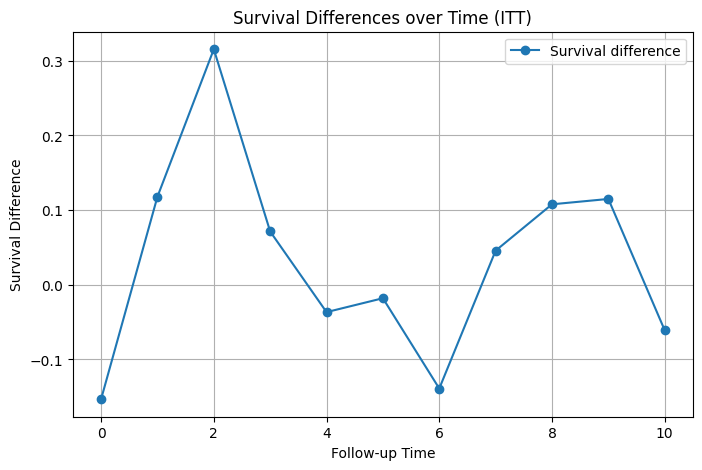

In [11]:
plt.figure(figsize=(8,5))
plt.plot(preds['followup_time'], preds['survival_diff'], label='Survival difference', marker='o')
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.title("Survival Differences over Time (ITT)")
plt.legend()
plt.grid(True)
plt.show()

# Cell 12: Deep Insights and Findings with Clustering Integration
In this analysis, we began by simulating a dataset similar to that used in trial emulation studies and subsequently applied a clustering algorithm (KMeans) on key baseline covariates such as age, x1, x2, and x3. The clustering step revealed three distinct patient subgroups with similar baseline profiles. Visualizing the clusters provided an intuitive understanding of potential heterogeneity in the study population.

After integrating the clustering results by adding the cluster membership as a categorical covariate in the ITT outcome model, we observed that the inclusion of this information could help explain some variability in treatment response. In particular, the cluster-adjusted outcome model may capture subgroup-specific characteristics that influence survival outcomes.

The subsequent steps of expanding the data for repeated follow-up, fitting a marginal structural model (MSM) with winsorized weights, and predicting survival differences over time provided a dynamic view of the treatment effect. Although the simulated data are simple, the approach illustrates several key points:
  
1. **Subgroup Identification:** The clustering mechanism identified patient subgroups that might respond differently to treatment. Incorporating cluster membership in the outcome model allows for the detection of subgroup-specific effects, which is crucial in personalized medicine or targeted interventions.
  
2. **Enhanced Model Specification:** By adjusting for both continuous covariates (such as x2) and the categorical cluster variable, the outcome model can better account for baseline heterogeneity. This may lead to more accurate estimates of the treatment effect.
  
3. **Dynamic Treatment Effects:** The MSM fitted on the expanded longitudinal data reveals how the treatment effect (proxied by survival differences) evolves over time. This dynamic analysis is essential in time-to-event studies where the effect may change as follow-up time increases.
  
4. **Potential Extensions:** While our example uses a basic KMeans clustering and linear models, more advanced methods (such as hierarchical clustering or mixture models) and more sophisticated survival analysis techniques (e.g., Cox models or joint models) could further enhance the analysis. Such extensions would be particularly useful when working with complex real-world datasets.
  
Overall, the integration of clustering into the trial emulation framework (TTE-v2) not only enriches the analysis by unveiling latent subgroups but also demonstrates how combining clustering with causal inference techniques can yield deeper insights into treatment effects over time.